# Report on Ensemble Empirical Mode Decomposition (EEMD) method

<font color=red> In JN 3.0-mb-decomposition-EEMD.ipynb we explain the different steps in more detail! Update this part!</font>

This technique aims at decomposing an input power signal into trend, seasonality and random components. The trend component is then used for computing the degradation factor (or equivalently the degradation rate). The methodology has the three following steps:
- First, we apply EEMD algorithm. This step takes as input a power signal and outputs a set of oscillatory functions (see below for more details).
- Second, we obtain the spectral representation of the oscillatory functions by Fourier transform (FT). According to their power spectrum, the oscillatory functions are grouped into trend, seasonal and random components. 
- Finally, we estimate the degradation factor (or equivalently the degradation rate) from the trend component.

EEMD is a data-driven, adaptive decomposition method which is a generalization of the Empirical Mode Decomposition (EMD) method. EMD is a technique for decomposing an input signal into a set of oscillatory components named Intrinsic Mode Functions (IMFs). The IMFs must satisfy the following two conditions:
1. the number of extrema and the number of zero-crossings must be the same or differ at most by one
2. at any point, the mean value of the envelope defined by the local maxima and the envelope defined by the local minima is zero.

For a description of the EMD algorithm see [[1]](https://srcole.github.io/2016/01/18/emd/) or [[2]](https://www.hindawi.com/journals/jece/2008/293056/). EEMD uses *M* slightly perturbed copies of the input signal, and applies EMD to each of these copies. Thus, obtaining one set of IMFs for each perturbed signal. The output set of IMFs is obtained by averaging over the ensemble of IMFs, in this way the noise cancels out.

The notebook is organized as follows. In the first part, we apply the methodology to one basic dataset. We generalize for all datasets for the basic idelized PV plant at the second part of the notebook.

**Open Questions**

- What about precision??

**Conclusions/Summary**

- For the basic synthetic catalog, we obtain a **RMSE of 0.46%\year**. This method does not perform well in estimating a slowly varying degradation rate, and it is better suite for estimating periodical effects.
- The first step of EEMD is to generate a set of perturbed copies of the input signal. These copies are generated by adding noise to the input signal. Since the generation of the noise is random, EEMD is a stochastic process. The results obtained with this method heavily relies on this first step, and I haven't achieved convergence. That is, if I rerun the code for a different noise's seed, the results are different. 

**Resources/Bibliograpy**

- [1] [Empirical Mode Decomposition (EMD)](https://srcole.github.io/2016/01/18/emd/)
- [2] [EMD](https://www.hindawi.com/journals/jece/2008/293056/)
- [3] [Ensemble Empirical Mode Decomposition (EEMD)](https://www.worldscientific.com/doi/abs/10.1142/S1793536909000047)
- [4] [EEMD + LSTM](https://link.springer.com/article/10.1007/s11269-019-02345-1)

**Requirements**

- [PyEMD](https://buildmedia.readthedocs.org/media/pdf/pyemd/latest/pyemd.pdf)

In [2]:
# In the root of the repo run "pip install --editable ."

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Replace sample_func_dir by the name of directory in src/ and replace sample_func_file the
# file name in src/sample_func_dir

from src.data.import_data import import_df_from_zip_pkl, import_df_info_from_zip
from src.data.make_dataset import *
from scipy import fftpack
import matplotlib.pyplot as plt
%matplotlib inline
from PyEMD import EMD, EEMD
from scipy import fftpack
from sklearn.metrics import mean_squared_error

In [17]:
def EEMD_decomposition(signal):
    """
    Decomposes signal into a set of oscillatory functions 
    named Intrinsic Mode Functions (IMFs)
        
    """
    # Initialize EEMD class
    eemd   = EEMD(spline_kind="cubic", extrema_detection="parabol", trials=200, noise_width=0.01)
    eemd.noise_seed(1)
    eIMFs  = eemd.eemd(signal)
    _, res = eemd.get_imfs_and_residue()
    nIMFs  = eIMFs.shape[0]
    return eIMFs, res, nIMFs

def FT_IMFs(eIMFs, nIMFs):
    box_length  = eIMFs[0].size
    #sample_freq = fftpack.fftfreq(box_length, d=1)
    power_IMFs  = np.ones((nIMFs, box_length), dtype=complex)
    for n in range(nIMFs):
        power_IMFs[n] = fftpack.fft(eIMFs[n])
    return power_IMFs

# m denotes the number of examples
def gradientDescent(x, y, theta, alpha, m, numIterations=100000):
    """
    Batch gradient descent for linear regression
    """
    for i in range(0, numIterations):
        hypothesis = np.transpose(np.matmul(x, theta))
        #loss       = hypothesis - y
        #cost       = np.sum(loss**2)/(2*m)
        #print("Iteration %d | Cost: %f" % (i, cost))
        theta      = theta - alpha/m*np.transpose(np.matmul(hypothesis - y, x))
    return theta

## Basic

Load datasets

In [121]:
synth_name  = "basic"
path_to_zip = "../data/raw/synthetic_" + synth_name + ".zip"
df          = {}
for csv_index in range(1, 50):
    df[csv_index] = import_df_from_zip_pkl(path_to_zip, index=csv_index, verbose=True)
    
_df_info = import_df_info_from_zip(path_to_zip, verbose=True)
rd_true  = df_info.Degradation_rate_linear.to_numpy()      

time for importing dataframe: 0.60 seconds
time for importing dataframe: 0.61 seconds
time for importing dataframe: 0.61 seconds
time for importing dataframe: 0.61 seconds
time for importing dataframe: 0.64 seconds
time for importing dataframe: 0.65 seconds
time for importing dataframe: 0.66 seconds
time for importing dataframe: 0.65 seconds
time for importing dataframe: 0.60 seconds
time for importing dataframe: 0.61 seconds
time for importing dataframe: 0.62 seconds
time for importing dataframe: 0.63 seconds
time for importing dataframe: 0.64 seconds
time for importing dataframe: 0.60 seconds
time for importing dataframe: 0.66 seconds
time for importing dataframe: 0.65 seconds
time for importing dataframe: 0.68 seconds
time for importing dataframe: 0.64 seconds
time for importing dataframe: 0.69 seconds
time for importing dataframe: 0.65 seconds
time for importing dataframe: 0.69 seconds
time for importing dataframe: 0.63 seconds
time for importing dataframe: 0.64 seconds
time for im

Preprocess datasets

In [122]:
for csv_index in range(1, 50):
    df[csv_index] = downsample_dataframe(df[csv_index], night_method='basic', clip_method='universal')
    df[csv_index]["ln_power"] = np.log(df[csv_index].Power.to_numpy())

Run EEMD

In [123]:
eIMFs = {}
nIMFs = {}
res   = {}

for csv_index in range(1, 50):
    _eIMFs, _res, _nIMFs = EEMD_decomposition(df[csv_index].ln_power.to_numpy())
    eIMFs[csv_index]     = _eIMFs
    nIMFs[csv_index]     = _nIMFs
    res[csv_index]       = _res

FT

In [124]:
power_IMFs = {}
for csv_index in range(1, 50):
    _power                = FT_IMFs(eIMFs[csv_index], nIMFs[csv_index])
    power_IMFs[csv_index] = _power

Calculate trend, and therefore, predicted degradation factor

In [178]:
emd         = EMD()
trend       = {}
eta_d_pred0 = {}
for csv_index in range(1, 50):
    box_length       = df[csv_index].Power.to_numpy().size
    trend[csv_index] = np.zeros(box_length)
    sample_freq      = fftpack.fftfreq(box_length, d=1)
    for n in range(nIMFs[csv_index]):
        max_pos, _, min_pos, _, _ = emd.find_extrema(sample_freq, np.abs(power_IMFs[csv_index][n]))
        #print (i, max_pos.shape[0], min_pos.shape[0])
        if  max_pos.shape[0]<2 and min_pos.shape[0]<2:
            trend[csv_index] = trend[csv_index] + eIMFs[csv_index][n]
            print ("csv_index = %i - Inside if conditon for nIMFs %i" %(csv_index, n))
    eta_d_pred0[csv_index] = np.exp(trend[csv_index])/np.exp(trend[csv_index][0])

csv_index = 1 - Inside if conditon for nIMFs 7
csv_index = 2 - Inside if conditon for nIMFs 7
csv_index = 3 - Inside if conditon for nIMFs 7
csv_index = 3 - Inside if conditon for nIMFs 8
csv_index = 4 - Inside if conditon for nIMFs 6
csv_index = 4 - Inside if conditon for nIMFs 7
csv_index = 5 - Inside if conditon for nIMFs 6
csv_index = 5 - Inside if conditon for nIMFs 7
csv_index = 6 - Inside if conditon for nIMFs 7
csv_index = 7 - Inside if conditon for nIMFs 7
csv_index = 8 - Inside if conditon for nIMFs 6
csv_index = 8 - Inside if conditon for nIMFs 7
csv_index = 8 - Inside if conditon for nIMFs 8
csv_index = 9 - Inside if conditon for nIMFs 7
csv_index = 9 - Inside if conditon for nIMFs 8
csv_index = 10 - Inside if conditon for nIMFs 7
csv_index = 10 - Inside if conditon for nIMFs 8
csv_index = 11 - Inside if conditon for nIMFs 7
csv_index = 12 - Inside if conditon for nIMFs 7
csv_index = 13 - Inside if conditon for nIMFs 7
csv_index = 13 - Inside if conditon for nIMFs 8
csv_ind

Calculate degradation factor

In [180]:
theta_init = np.array([[1], [0]]) # initial guess for linear regression parameters
eta_d_pred = {} # degradation factor
rd_pred0   = {} # degradation rate
rd_pred    = []
for csv_index in range(1, 50):
    x     = np.arange(1, len(trend[csv_index]) + 1, 1)
    x     = np.concatenate((np.ones(len(trend[csv_index])), x))
    x     = np.transpose(x.reshape(2, len(trend[csv_index])))
    y     = eta_d_pred0[csv_index]
    y     = np.array(y, ndmin=2)
    theta = gradientDescent(x, y, theta_init, 1e-7, len(trend[csv_index]), numIterations=1000)

    eta_d_pred[csv_index] = np.matmul(x, theta)
    time  = np.arange(1, len(eta_d_pred[csv_index]) + 1, 1) / 365. # [years]
    rd_pred0[csv_index] = np.divide(eta_d_pred[csv_index][:, 0] - 1, time)
    rd_pred.append(np.mean(rd_pred0[csv_index]))

rd_pred = np.array(rd_pred)

In [182]:
RMSE = np.sqrt(mean_squared_error(rd_true[1:]*100, rd_pred*100))
print ("RMSE = %.3f percentage/year" %(RMSE))

RMSE = 0.465 percentage/year


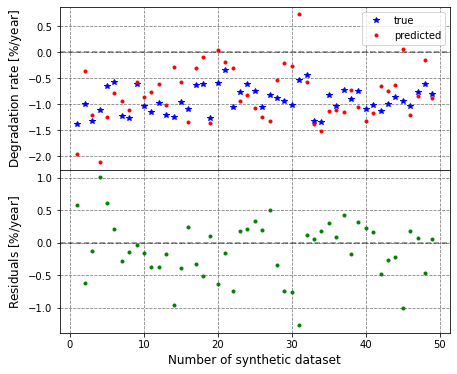

In [183]:
fig, ax = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
ax[0].plot(np.arange(1, 50, 1), rd_true[1:]*100, "b*", label="true")
ax[0].plot(np.arange(1, 50, 1), rd_pred*100, "r.", label="predicted")
ax[0].legend(fontsize=10)
ax[0].set_ylabel(r"Degradation rate [$\%$/year]", fontsize=12)
ax[0].axhline(0., ls="--", color="k", alpha=0.5)
ax[0].grid(ls="--", color="k", alpha=0.5)

ax[1].plot(np.arange(1, 50, 1), (rd_true[1:]-rd_pred)*100, "g.")
ax[1].set_ylabel(r"Residuals [$\%$/year]", fontsize=12)
ax[1].set_xlabel("Number of synthetic dataset", fontsize=12)
ax[1].axhline(0., ls="--", color="k", alpha=0.5)
ax[1].grid(ls="--", color="k", alpha=0.5)

plt.subplots_adjust(hspace=0)

## Soil

Load datasets

In [7]:
synth_name  = "soil"
path_to_zip = "../data/raw/synthetic_" + synth_name + ".zip"
df          = {}
for csv_index in range(0, 50):
    df[csv_index] = import_df_from_zip_pkl(path_to_zip, index=csv_index, verbose=True)
    
df_info = import_df_info_from_zip(path_to_zip, verbose=True)
rd_true  = df_info.Degradation_rate_linear.to_numpy()  


importing synthetic_soil/synthetic_soil_001.pkl

time for importing dataframe: 0.57 seconds

importing synthetic_soil/synthetic_soil_002.pkl

time for importing dataframe: 0.59 seconds

importing synthetic_soil/synthetic_soil_003.pkl

time for importing dataframe: 0.57 seconds

importing synthetic_soil/synthetic_soil_004.pkl

time for importing dataframe: 0.58 seconds

importing synthetic_soil/synthetic_soil_005.pkl

time for importing dataframe: 0.58 seconds

importing synthetic_soil/synthetic_soil_006.pkl

time for importing dataframe: 0.58 seconds

importing synthetic_soil/synthetic_soil_007.pkl

time for importing dataframe: 0.56 seconds

importing synthetic_soil/synthetic_soil_008.pkl

time for importing dataframe: 0.56 seconds

importing synthetic_soil/synthetic_soil_009.pkl

time for importing dataframe: 0.57 seconds

importing synthetic_soil/synthetic_soil_010.pkl

time for importing dataframe: 0.58 seconds

importing synthetic_soil/synthetic_soil_011.pkl

time for importing d

NameError: name 'df_info' is not defined

Preprocess datasets

In [10]:
for csv_index in range(1, 50):
    df[csv_index] = downsample_dataframe(df[csv_index], night_method='basic', clip_method='universal')
    df[csv_index]["ln_power"] = np.log(df[csv_index].Power.to_numpy())

Run EEMD

In [11]:
eIMFs = {}
nIMFs = {}
res   = {}

for csv_index in range(1, 50):
    _eIMFs, _res, _nIMFs = EEMD_decomposition(df[csv_index].ln_power.to_numpy())
    eIMFs[csv_index]     = _eIMFs
    nIMFs[csv_index]     = _nIMFs
    res[csv_index]       = _res

FT

In [14]:
power_IMFs = {}
for csv_index in range(1, 50):
    _power                = FT_IMFs(eIMFs[csv_index], nIMFs[csv_index])
    power_IMFs[csv_index] = _power

Calculate trend, and therefore, predicted degradation factor

In [15]:
emd         = EMD()
trend       = {}
eta_d_pred0 = {}
for csv_index in range(1, 50):
    box_length       = df[csv_index].Power.to_numpy().size
    trend[csv_index] = np.zeros(box_length)
    sample_freq      = fftpack.fftfreq(box_length, d=1)
    for n in range(nIMFs[csv_index]):
        max_pos, _, min_pos, _, _ = emd.find_extrema(sample_freq, np.abs(power_IMFs[csv_index][n]))
        #print (i, max_pos.shape[0], min_pos.shape[0])
        if  max_pos.shape[0]<2 and min_pos.shape[0]<2:
            trend[csv_index] = trend[csv_index] + eIMFs[csv_index][n]
            print ("csv_index = %i - Inside if conditon for nIMFs %i" %(csv_index, n))
    eta_d_pred0[csv_index] = np.exp(trend[csv_index])/np.exp(trend[csv_index][0])

csv_index = 1 - Inside if conditon for nIMFs 8
csv_index = 2 - Inside if conditon for nIMFs 7
csv_index = 2 - Inside if conditon for nIMFs 8
csv_index = 3 - Inside if conditon for nIMFs 7
csv_index = 3 - Inside if conditon for nIMFs 8
csv_index = 4 - Inside if conditon for nIMFs 7
csv_index = 4 - Inside if conditon for nIMFs 8
csv_index = 5 - Inside if conditon for nIMFs 7
csv_index = 5 - Inside if conditon for nIMFs 8
csv_index = 6 - Inside if conditon for nIMFs 7
csv_index = 6 - Inside if conditon for nIMFs 8
csv_index = 7 - Inside if conditon for nIMFs 7
csv_index = 7 - Inside if conditon for nIMFs 8
csv_index = 8 - Inside if conditon for nIMFs 8
csv_index = 9 - Inside if conditon for nIMFs 8
csv_index = 10 - Inside if conditon for nIMFs 7
csv_index = 10 - Inside if conditon for nIMFs 8
csv_index = 11 - Inside if conditon for nIMFs 7
csv_index = 12 - Inside if conditon for nIMFs 7
csv_index = 12 - Inside if conditon for nIMFs 8
csv_index = 13 - Inside if conditon for nIMFs 7
csv_ind

Calculate degradation factor

In [19]:
theta_init = np.array([[1], [0]]) # initial guess for linear regression parameters
eta_d_pred = {} # degradation factor
rd_pred0   = {} # degradation rate
rd_pred    = []
for csv_index in range(1, 50):
    x     = np.arange(1, len(trend[csv_index]) + 1, 1)
    x     = np.concatenate((np.ones(len(trend[csv_index])), x))
    x     = np.transpose(x.reshape(2, len(trend[csv_index])))
    y     = eta_d_pred0[csv_index]
    y     = np.array(y, ndmin=2)
    theta = gradientDescent(x, y, theta_init, 1e-7, len(trend[csv_index]), numIterations=1000)

    eta_d_pred[csv_index] = np.matmul(x, theta)
    time  = np.arange(1, len(eta_d_pred[csv_index]) + 1, 1) / 365. # [years]
    rd_pred0[csv_index] = np.divide(eta_d_pred[csv_index][:, 0] - 1, time)
    rd_pred.append(np.mean(rd_pred0[csv_index]))

rd_pred = np.array(rd_pred)

In [22]:
RMSE = np.sqrt(mean_squared_error(rd_true[1:]*100, rd_pred*100))
print ("RMSE = %.3f percentage/year" %(RMSE))

RMSE = 1.184 percentage/year


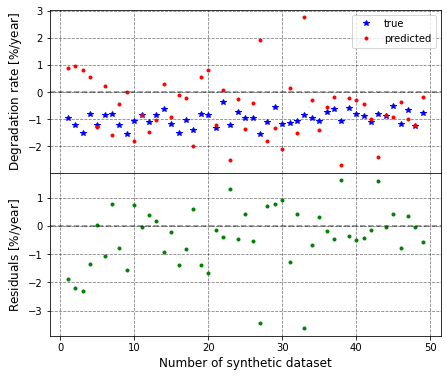

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
ax[0].plot(np.arange(1, 50, 1), rd_true[1:]*100, "b*", label="true")
ax[0].plot(np.arange(1, 50, 1), rd_pred*100, "r.", label="predicted")
ax[0].legend(fontsize=10)
ax[0].set_ylabel(r"Degradation rate [$\%$/year]", fontsize=12)
ax[0].axhline(0., ls="--", color="k", alpha=0.5)
ax[0].grid(ls="--", color="k", alpha=0.5)

ax[1].plot(np.arange(1, 50, 1), (rd_true[1:]-rd_pred)*100, "g.")
ax[1].set_ylabel(r"Residuals [$\%$/year]", fontsize=12)
ax[1].set_xlabel("Number of synthetic dataset", fontsize=12)
ax[1].axhline(0., ls="--", color="k", alpha=0.5)
ax[1].grid(ls="--", color="k", alpha=0.5)

plt.subplots_adjust(hspace=0)

## Weather

Load datasets

In [24]:
synth_name  = "weather"
path_to_zip = "../data/raw/synthetic_" + synth_name + ".zip"
df          = {}
for csv_index in range(0, 50):
    df[csv_index] = import_df_from_zip_pkl(path_to_zip, index=csv_index, verbose=True)
    
df_info = import_df_info_from_zip(path_to_zip, verbose=True)
rd_true  = df_info.Degradation_rate_linear.to_numpy()  


importing synthetic_weather/synthetic_weather_001.pkl

time for importing dataframe: 0.68 seconds

importing synthetic_weather/synthetic_weather_002.pkl

time for importing dataframe: 0.66 seconds

importing synthetic_weather/synthetic_weather_003.pkl

time for importing dataframe: 0.69 seconds

importing synthetic_weather/synthetic_weather_004.pkl

time for importing dataframe: 0.70 seconds

importing synthetic_weather/synthetic_weather_005.pkl

time for importing dataframe: 0.65 seconds

importing synthetic_weather/synthetic_weather_006.pkl

time for importing dataframe: 0.63 seconds

importing synthetic_weather/synthetic_weather_007.pkl

time for importing dataframe: 0.70 seconds

importing synthetic_weather/synthetic_weather_008.pkl

time for importing dataframe: 0.64 seconds

importing synthetic_weather/synthetic_weather_009.pkl

time for importing dataframe: 0.65 seconds

importing synthetic_weather/synthetic_weather_010.pkl

time for importing dataframe: 0.70 seconds

importing

Preprocess datasets

In [25]:
for csv_index in range(0, 50):
    df[csv_index] = downsample_dataframe(df[csv_index], night_method='basic', clip_method='universal')
    df[csv_index]["ln_power"] = np.log(df[csv_index].Power.to_numpy())

Run EEMD

In [27]:
eIMFs = {}
nIMFs = {}
res   = {}

for csv_index in range(0, 50):
    _eIMFs, _res, _nIMFs = EEMD_decomposition(df[csv_index].ln_power.to_numpy())
    eIMFs[csv_index]     = _eIMFs
    nIMFs[csv_index]     = _nIMFs
    res[csv_index]       = _res

FT

In [28]:
power_IMFs = {}
for csv_index in range(0, 50):
    _power                = FT_IMFs(eIMFs[csv_index], nIMFs[csv_index])
    power_IMFs[csv_index] = _power

Calculate trend, and therefore, predicted degradation factor

In [30]:
emd         = EMD()
trend       = {}
eta_d_pred0 = {}
for csv_index in range(0, 50):
    box_length       = df[csv_index].Power.to_numpy().size
    trend[csv_index] = np.zeros(box_length)
    sample_freq      = fftpack.fftfreq(box_length, d=1)
    for n in range(nIMFs[csv_index]):
        max_pos, _, min_pos, _, _ = emd.find_extrema(sample_freq, np.abs(power_IMFs[csv_index][n]))
        #print (i, max_pos.shape[0], min_pos.shape[0])
        if  max_pos.shape[0]<2 and min_pos.shape[0]<2:
            trend[csv_index] = trend[csv_index] + eIMFs[csv_index][n]
            print ("csv_index = %i - Inside if conditon for nIMFs %i" %(csv_index, n))
    eta_d_pred0[csv_index] = np.exp(trend[csv_index])/np.exp(trend[csv_index][0])

csv_index = 0 - Inside if conditon for nIMFs 0
csv_index = 0 - Inside if conditon for nIMFs 1
csv_index = 1 - Inside if conditon for nIMFs 0
csv_index = 1 - Inside if conditon for nIMFs 1
csv_index = 2 - Inside if conditon for nIMFs 8
csv_index = 3 - Inside if conditon for nIMFs 0
csv_index = 3 - Inside if conditon for nIMFs 1
csv_index = 4 - Inside if conditon for nIMFs 0
csv_index = 4 - Inside if conditon for nIMFs 1
csv_index = 5 - Inside if conditon for nIMFs 0
csv_index = 5 - Inside if conditon for nIMFs 1
csv_index = 6 - Inside if conditon for nIMFs 0
csv_index = 6 - Inside if conditon for nIMFs 1
csv_index = 7 - Inside if conditon for nIMFs 8
csv_index = 8 - Inside if conditon for nIMFs 0
csv_index = 8 - Inside if conditon for nIMFs 1
csv_index = 9 - Inside if conditon for nIMFs 0
csv_index = 9 - Inside if conditon for nIMFs 1
csv_index = 10 - Inside if conditon for nIMFs 0
csv_index = 10 - Inside if conditon for nIMFs 1
csv_index = 11 - Inside if conditon for nIMFs 8
csv_index 

Calculate degradation factor

In [31]:
theta_init = np.array([[1], [0]]) # initial guess for linear regression parameters
eta_d_pred = {} # degradation factor
rd_pred0   = {} # degradation rate
rd_pred    = []
for csv_index in range(0, 50):
    x     = np.arange(1, len(trend[csv_index]) + 1, 1)
    x     = np.concatenate((np.ones(len(trend[csv_index])), x))
    x     = np.transpose(x.reshape(2, len(trend[csv_index])))
    y     = eta_d_pred0[csv_index]
    y     = np.array(y, ndmin=2)
    theta = gradientDescent(x, y, theta_init, 1e-7, len(trend[csv_index]), numIterations=1000)

    eta_d_pred[csv_index] = np.matmul(x, theta)
    time  = np.arange(1, len(eta_d_pred[csv_index]) + 1, 1) / 365. # [years]
    rd_pred0[csv_index] = np.divide(eta_d_pred[csv_index][:, 0] - 1, time)
    rd_pred.append(np.mean(rd_pred0[csv_index]))

rd_pred = np.array(rd_pred)

In [36]:
rd_true, rd_pred

(array([-0.01292057, -0.00193295, -0.00909054, -0.00726817, -0.00547889,
        -0.00796208, -0.01005266, -0.01628736, -0.00842933, -0.01179946,
        -0.00596632, -0.01637533, -0.00863041, -0.00786658, -0.01085508,
        -0.00871537, -0.00928168, -0.00744126, -0.0142474 , -0.01208324,
        -0.01346945, -0.00650422, -0.00746249, -0.00979029, -0.0131995 ,
        -0.01046213, -0.01177202, -0.00613061, -0.00526756, -0.00992986,
        -0.0149551 , -0.01405223, -0.00921661, -0.01341297, -0.01164116,
        -0.01606625, -0.00627239, -0.01358562, -0.01148616, -0.01500067,
        -0.00597155, -0.01217605, -0.00743494, -0.00376129, -0.0123352 ,
        -0.01584127, -0.00825535, -0.00813567, -0.01067284, -0.01478451]),
 array([        nan,         nan,  0.02128712,         nan,         nan,
                nan,         nan, -0.00011416,         nan,         nan,
                nan, -0.00589205, -0.00484394,         nan, -0.0703088 ,
                nan,         nan,         nan,   

In [34]:
RMSE = np.sqrt(mean_squared_error(rd_true[1:]*100, rd_pred*100))
print ("RMSE = %.3f percentage/year" %(RMSE))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

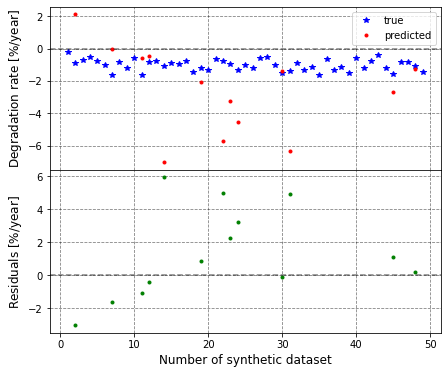

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
ax[0].plot(np.arange(1, 50, 1), rd_true[1:]*100, "b*", label="true")
ax[0].plot(np.arange(1, 50, 1), rd_pred[1:]*100, "r.", label="predicted")
ax[0].legend(fontsize=10)
ax[0].set_ylabel(r"Degradation rate [$\%$/year]", fontsize=12)
ax[0].axhline(0., ls="--", color="k", alpha=0.5)
ax[0].grid(ls="--", color="k", alpha=0.5)

ax[1].plot(np.arange(1, 50, 1), (rd_true[1:]-rd_pred[1:])*100, "g.")
ax[1].set_ylabel(r"Residuals [$\%$/year]", fontsize=12)
ax[1].set_xlabel("Number of synthetic dataset", fontsize=12)
ax[1].axhline(0., ls="--", color="k", alpha=0.5)
ax[1].grid(ls="--", color="k", alpha=0.5)

plt.subplots_adjust(hspace=0)